In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import get_data
from numba import jit
from typing import Optional, Union, List

In [2]:
df = get_data('NQ')
df = df.loc['20180901': '20190331']
dfp = df[[ 'high', 'low',]]
n = dfp.to_numpy()
n.shape

(200265, 2)

In [3]:
@jit(nopython=True)
def swing_2(data: np.array, f: float) -> np.array:
    state = np.ones((data.shape[0], 1), dtype=np.int8)
    extreme = np.zeros(state.shape)
    extreme[0] = data[0,0]
    pivot = np.zeros(state.shape)
    pivot[0] = data[0, 0]
    signal = np.ones(state.shape, dtype=np.int8)
    signal[0] = 1
    max_pivot = np.array([data[0, 0]])
    min_pivot = np.array([data[0, 1]])
    max_list = np.zeros(state.shape)
    min_list = np.zeros(state.shape)
    for i, row in enumerate(data):
        #print(f'{i} row: {row}, extreme: {extreme[i-1]}')
        if i == 0:
            continue          

        if state[i-1, 0] == 1:   
            if (row[0] > max_pivot[0]): 
                signal[i] = 1
            else:
                signal[i] = signal[i-1]
                
            if extreme[i-1, 0] - row[1] > f:
                state[i] = -1
                extreme[i] = row[1]
                pivot[i] = extreme[i-1]
                max_pivot = pivot[i]
                max_list[i] = max_pivot
            else:
                state[i] = 1
                extreme[i] = max(extreme[i-1, 0], row[0])
                pivot[i] = pivot[i-1]
            
        elif state[i-1, 0] == -1:  
            if (row[1] < min_pivot[0]):
                signal[i] = -1
            else:
                signal[i] =signal[i-1]
                
            if np.abs(extreme[i-1, 0] - row[0]) > f:
                state[i] = 1
                extreme[i] = row[0]
                pivot[i] = extreme[i-1]
                min_pivot = pivot[i]
                min_list[i] = min_pivot
            else:
                state[i, 0] = -1
                extreme[i] = min(extreme[i-1, 0], row[1])
                pivot[i] = pivot[i-1]
            
            
        else:
            raise ValueError('Wrong state value!')
        #print(f'pivot: {pivot[i]}, extreme: {extreme[i]}, signal: {signal[i]}, state: {state[i,0]}')
        #print(f'min_pivot: {min_pivot}, max_pivot: {max_pivot}')      
        #print('---------------')
    return np.concatenate((state, extreme, pivot, signal, max_list, min_list), axis=1)

In [4]:
df3 = df.copy()
df3[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing_2(df3[['high', 'low']].to_numpy(), 75)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].replace(0.0, np.nan)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].fillna(method='ffill')
df3

,open,high,low,close,volume,average,barCount,swing,extreme,pivot,signal,max_list,min_list
date,,,,,,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0,7675.0,7675.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0,7414.5,7276.0,-1.0,7447.5,7276.0


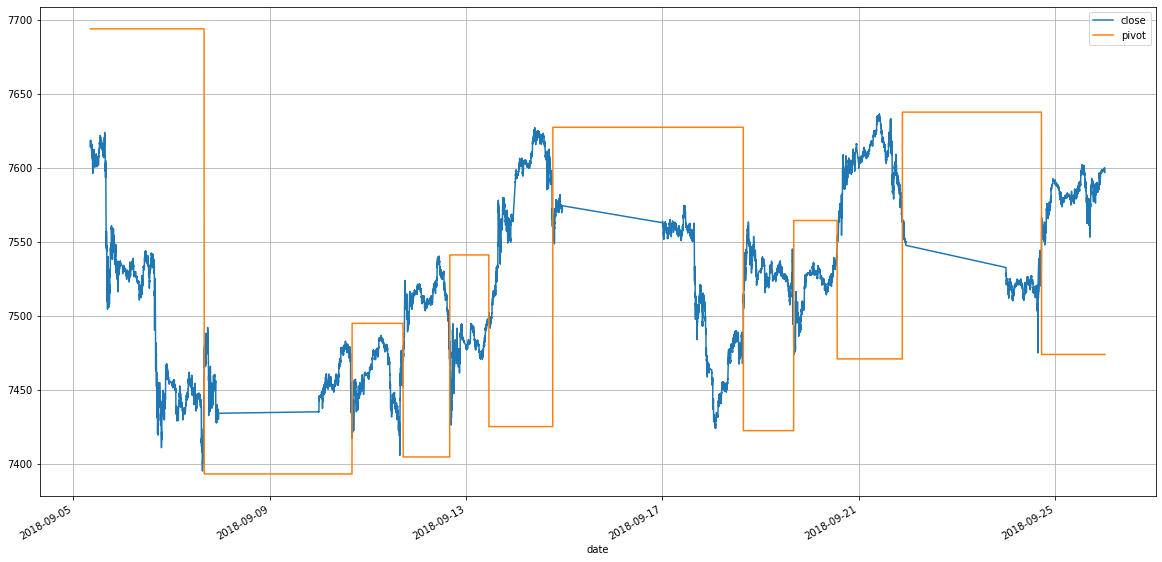

In [5]:
t = df3.iloc[3000:23000]
t[['close', 'pivot']].plot(figsize=(20,10), grid=True);

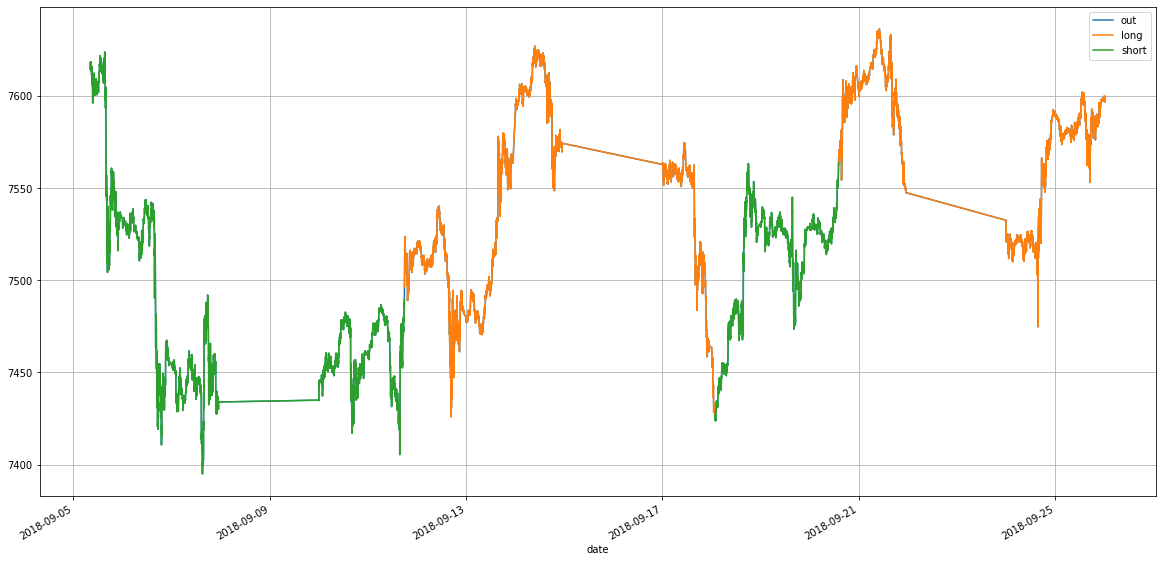

In [6]:
chart_price(t['close'], t['signal']);

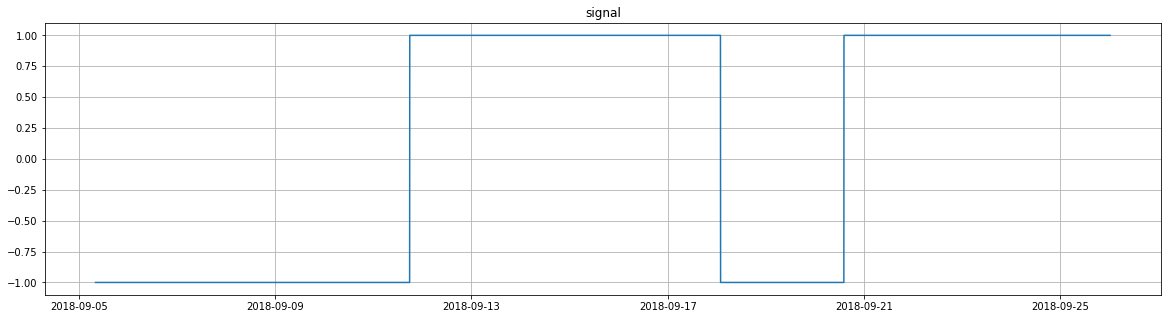

In [7]:
plot(t.signal);

In [8]:
def swing_chart_data(df: pd.DataFrame, keep_columns: Optional[Union[List, str]] = None) -> pd.DataFrame:
    df = df.copy()
    df['swing_point'] = (df['swing'] != df['swing'].shift()) * 1
    df['swing_price'] = df['swing_point'] * df['extreme'].shift().fillna(method='bfill')
    df['close_price'] = df['swing_point'] * df['close']
    output_columns = ['swing_price', 'close_price']
    if keep_columns:
        if isinstance(keep_columns, str):
            keep_columns = [keep_columns]
        output_columns.extend(keep_columns)
    swing_df = df[df['swing_price'] != 0].loc[:, output_columns]
    swing_df.reset_index(drop=True, inplace=True)
    return swing_df

In [9]:
swing_chart = swing_chart_data(t)
swing_chart

,swing_price,close_price
0,7586.75,7618.00
1,7393.00,7474.25
2,7494.75,7418.25
3,7404.50,7479.50
4,7541.00,7466.00
5,7425.00,7502.00
6,7627.25,7551.75
7,7422.25,7494.25
8,7564.25,7484.75
9,7470.75,7545.50


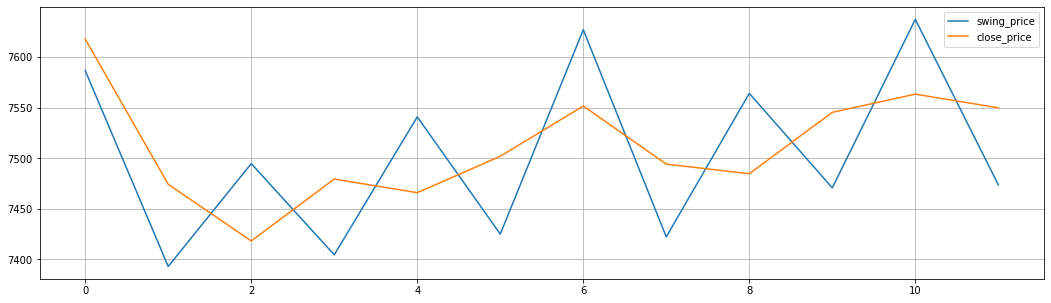

In [10]:
swing_chart.plot(figsize=(18,5), grid=True, secondary_y='signal');

In [11]:
def sim(price, indicator, slip=1.5, threshold=0):
    b = v_backtester(price, indicator, threshold)
    r = perf_var(b, False, slippage=slip)
    return r.stats, r.daily['returns']

In [12]:
out = sim(t['close'], t['signal'])
out[0]

Annual return                 -0.148074
Cumulative returns           -0.0101234
Annual volatility              0.135681
Sharpe ratio                    -1.1169
Calmar ratio                   -3.60334
Stability                      0.679543
Max drawdown                 -0.0410936
Omega ratio                    0.821237
Sortino ratio                  -1.43825
Skew                          -0.575655
Kurtosis                     -0.0400198
Tail ratio                     0.686112
Daily value at risk          -0.0176955
Win percent                         0.5
Average gain                         74
Average loss                   -109.125
Avg gain/loss ratio            0.678121
Position EV                    -17.5625
Positions per day                  0.25
Days per position                     4
Actual avg. duration    5 days 04:01:00
Days                                 16
Positions                             4
Trades                                7
Monthly EV                     -92.2031


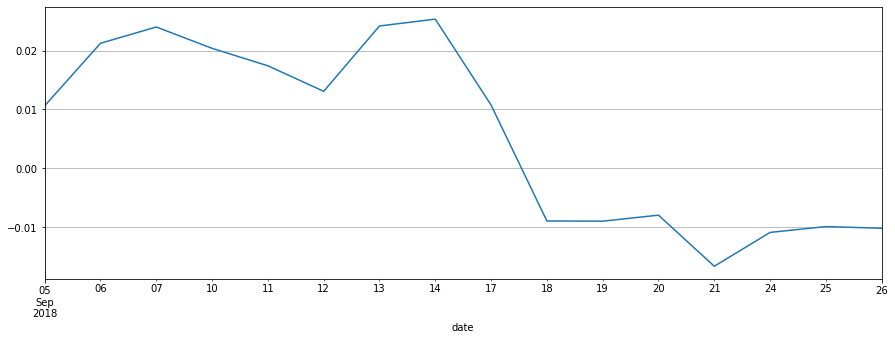

In [13]:
np.log(out[1]+1).cumsum().plot(figsize=(15, 5), grid=True);

In [14]:
f = [i for i in range(40, 320, 20)]
df4 = df.copy()
for i in f:
    df4[i] = swing_2(n, i)[:,3]

In [15]:
def stats(df, f):
    results = pd.DataFrame()
    for i in f:
        try:
            results[i] = sim(df4['close'], df[i])[0]
        except:
            continue
    return results

In [16]:
stats(df4[3000:], f)

,40,60,80,100,120,140,160,180,200,220,240,260,280,300
Annual return,-0.172229,0.0492967,0.0487007,0.0282447,-0.194145,0.0808511,-0.216486,-0.236029,-0.166214,-0.139992,0.159113,0.197013,-0.188821,0.0233076
Cumulative returns,-0.105071,0.0286642,0.028321,0.0164928,-0.119064,0.0467206,-0.13349,-0.14625,-0.101258,-0.0847635,0.0905889,0.111393,-0.11565,0.0136235
Annual volatility,0.2386,0.237234,0.225865,0.220435,0.242424,0.221715,0.238747,0.237032,0.238247,0.244345,0.240974,0.24224,0.243194,0.242411
Sharpe ratio,-0.672555,0.320646,0.322827,0.23627,-0.769301,0.460309,-0.90254,-1.01728,-0.644248,-0.495448,0.732416,0.862762,-0.739323,0.215354
Calmar ratio,-0.725325,0.339137,0.480148,0.288584,-1.0302,0.607027,-0.812434,-0.885249,-0.739573,-0.675086,1.28292,1.68911,-0.990065,0.159022
Stability,0.507942,0.148445,0.210007,0.354664,0.602429,0.206173,0.592178,0.608643,0.526542,0.424858,0.608816,0.633841,0.558536,0.194876
Max drawdown,-0.237452,-0.145359,-0.101429,-0.0978735,-0.188454,-0.133192,-0.266467,-0.266624,-0.224743,-0.207369,-0.124023,-0.116637,-0.190716,-0.146568
Omega ratio,0.887404,1.05918,1.05891,1.04397,0.867622,1.08576,0.848527,0.831263,0.88893,0.913755,1.14183,1.16853,0.873876,1.03996
Sortino ratio,-0.896272,0.465366,0.457867,0.323793,-1.04043,0.7066,-1.21776,-1.3748,-0.891629,-0.683331,1.11744,1.31923,-1.03556,0.318646
Skew,-0.590572,0.0411017,-0.082681,-0.403194,-0.120008,0.515077,-0.0749622,-0.0270327,0.000208868,-0.0825583,0.136754,0.110011,0.098913,0.106805


In [17]:
def combine(df, n):
    out = pd.DataFrame()
    out['close'] = df['close']
    for i in f:
        if i == n:
            continue
        out[i] = (df[i] + df[n]).clip(-1, 1)
    return out

In [18]:
stats(combine(df4[3000:], 120), f)

,40,60,80,100,140,160,180,200,220,240,260,280,300
Annual return,-0.173343,-0.072052,-0.0742189,-0.0868279,-0.0644049,-0.200797,-0.210734,-0.175278,-0.161875,-0.0255298,-0.00825674,-0.181637,-0.081085
Cumulative returns,-0.105778,-0.0429677,-0.0442809,-0.0519472,-0.0383437,-0.123342,-0.12976,-0.107009,-0.0985134,-0.0150736,-0.00485749,-0.111059,-0.0484502
Annual volatility,0.17476,0.191121,0.198683,0.217692,0.217285,0.210892,0.208999,0.208392,0.204067,0.191025,0.186134,0.184296,0.174578
Sharpe ratio,-1.00235,-0.296289,-0.289263,-0.308777,-0.198808,-0.957708,-1.02812,-0.821025,-0.763848,-0.0409165,0.0473422,-0.996127,-0.398106
Calmar ratio,-0.93506,-0.601889,-0.787509,-0.68937,-0.481721,-0.957174,-1.00414,-0.909476,-0.839929,-0.220812,-0.0880369,-1.15825,-0.663302
Stability,0.58082,0.151435,0.320576,0.203372,0.16714,0.676039,0.691249,0.622398,0.557778,0.00799889,0.0378325,0.70418,0.217107
Max drawdown,-0.185381,-0.11971,-0.0942452,-0.125953,-0.133697,-0.209781,-0.209866,-0.192724,-0.192724,-0.115618,-0.0937873,-0.156819,-0.122244
Omega ratio,0.82791,0.944046,0.947274,0.943125,0.963365,0.83077,0.819005,0.852197,0.856947,0.991515,1.00998,0.800899,0.911838
Sortino ratio,-1.4623,-0.422606,-0.408931,-0.42571,-0.290862,-1.30853,-1.40854,-1.13283,-1.06275,-0.061107,0.0727087,-1.43187,-0.597494
Skew,0.546594,0.0793433,-0.101479,-0.198406,0.451505,0.250437,0.30158,0.278395,0.312769,0.606487,0.827263,0.780742,0.918662


In [19]:
df5 = df.copy()
for i in f:
    df5[i] = swing_2(n, i)[:,0]

In [20]:
def combine_swing_direction(df1, df2, n, m):
    out = pd.DataFrame()
    out['close'] = df['close']
    out[n] = df1[n]
    out[m] = df2[m]
    out['combined'] = (df1[n] + df2[m]).clip(-1, 1)
    return out

In [21]:
stats(combine_swing_direction(df4, df5, 240, 60)[3000:], ['combined'])

,combined
Annual return,0.176609
Cumulative returns,0.100227
Annual volatility,0.169133
Sharpe ratio,1.04534
Calmar ratio,2.14655
Stability,0.601066
Max drawdown,-0.0822756
Omega ratio,1.20688
Sortino ratio,1.81165
Skew,0.872513


In [22]:
t = combine_swing_direction(df4, df5, 80, 60)
t

,close,80,60,combined
date,,,,
2018-09-03 00:00:00,7671.50,1.0,1.0,1.0
2018-09-03 00:01:00,7670.00,1.0,1.0,1.0
2018-09-03 00:02:00,7671.00,1.0,1.0,1.0
2018-09-03 00:03:00,7671.75,1.0,1.0,1.0
2018-09-03 00:04:00,7669.75,1.0,1.0,1.0
...,...,...,...,...
2019-03-29 21:55:00,7410.75,-1.0,1.0,0.0
2019-03-29 21:56:00,7410.50,-1.0,1.0,0.0
2019-03-29 21:57:00,7412.75,-1.0,1.0,0.0


In [35]:
a = pd.DataFrame()
a['x'] = np.linspace(1, 100, 3000)
a['y'] = np.log(a['x'])
a.set_index('x', inplace=True)
a

,y
x,
1.000000,0.000000
1.033011,0.032478
1.066022,0.063934
1.099033,0.094431
1.132044,0.124025
...,...
99.867956,4.603849
99.900967,4.604179
99.933978,4.604510


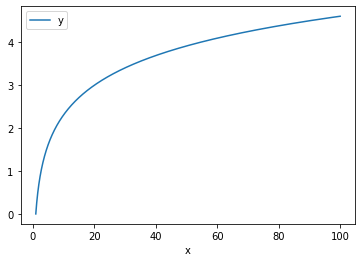

In [36]:
a.plot();